In [1]:
# load the autoreload extension
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A3 folder, then '2022WI/A3'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'EECS 568 Final Project','Code')
print(os.listdir(GOOGLE_DRIVE_PATH))

['Models', 'Data', 'SemanticKitti', 'Untitled0.ipynb', 'Predictions', '__pycache__', 'CarlaTest', '.ipynb_checkpoints', '3DMapping-main(UNUSED)', 'Benchmarking', 'MotionSC_node', 'ForwardPass_SemanticKitti_test.ipynb', 'CarlaFormatter.py']


In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)
print(sys.path)

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', 'drive/My Drive/EECS 568 Final Project/Code']


In [5]:
import sys
import os
import struct
import numpy as np
from sklearn.metrics import jaccard_score
import pdb
import time
# Filepaths for CatSBKI
pc_dataset_dir =  os.path.join('drive', 'My Drive', 'EECS 568 Final Project','Code', 'CarlaTest', 'Town10_Heavy', 'cartesian', 'velodyne' )
label_dataset_dir = os.path.join('drive', 'My Drive', 'EECS 568 Final Project','Code', 'CarlaTest', 'Town10_Heavy', 'cartesian', 'labels')
prediction_labels = os.path.join('drive', 'My Drive', 'EECS 568 Final Project', 'Code', 'Predictions', 'MotionSC_11', 'evaluations_edited') # Thanks Rohan ;)
# Filepaths for SBKI
# pc_dataset_dir =  os.path.join('drive', 'My Drive', 'EECS 568 Final Project','Code', 'CarlaTest', 'Town10_Heavy', 'cartesian', 'velodyne' )
# label_dataset_dir = os.path.join('drive', 'My Drive', 'EECS 568 Final Project','Code', 'CarlaTest', 'Town10_Heavy', 'cartesian', 'labels')
# prediction_labels = os.path.join('drive', 'My Drive', 'EECS 568 Final Project', 'Code', 'Predictions', 'MotionSC_11', 'SBKI_evaluations') # Thanks Rohan ;)
pc_files = sorted(os.listdir(pc_dataset_dir)) # sort the file name in order
label_files = sorted(os.listdir(label_dataset_dir))

# print(pc_files)
remapping_vector = [
    0, # Free
    1, # Building
    2, # Barrier
    3, # Other
    4, # Pedestrian
    5, # Pole or Traffic Light/Sign
    7, # Roadline -> Road
    7, # Road
    8, # Sidewalk
    9, # Vegetation
    10, # Vehicles
    2, # Wall -> Barrier
    5, # Traffic Sign -> Pole
    6, # Sky -> Other
    11, # Ground
    6, # Bridge -> Other
    6, # Railtrack -> Other
    2, # GuardRail -> Barrier
    5, # Traffic Light -> Pole
    6, # Static -> Other
    6, # Dynamic -> Other
    6, # Water -> Other
    11 # Terrain -> Ground
]
remapped_class_to_labels = [
    "Free",
    "Building",
    "Barrier",
    "Other",
    "Pedestrian",
    "Poles",
    "Other Remapped",
    "Road",
    "Sidewalk",
    "Vegetation",
    "Vehicles",
    "Ground"
]

num_frames = len(pc_files)
jaccard_score_result = np.zeros(12)
for idx in range(num_frames):

  # TODO: Once you puyt all the data, remove this
  # if idx > 100:
  #   break

  pc_filename   = pc_files[idx]
  pc_labelname  = label_files[idx]
  # print(pc_filename)
  pc_fp = os.path.join(pc_dataset_dir, pc_filename)
  pclabel_fp = os.path.join(label_dataset_dir, pc_labelname)
  
  min_bound = np.array([-25.6, -25.6, -2])
  max_bound = np.array([25.6, 25.6, 1])
  voxel_size = np.array([0.4, 0.4, 0.375])

  pc_file = open(pc_fp, mode='rb')
  pclabel_file = open(pclabel_fp, mode='rb')

  # fileContent = file.read()
  # n = int(len(fileContent)/16) # number of point clouds
  # location  = np.zeros((n,4)) 
  # for i in range(n):
  #   location[i,:] = struct.unpack("ffff", fileContent[16*i:16*(i+1)]) # ffff means convert 16 bytes data into 4 float numbers
  points = np.fromfile(pc_file, dtype=np.float32).reshape(-1, 4)[:, :3]
  
  points_label = np.fromfile(pclabel_file, dtype=np.uint32).reshape(-1, 1)
  # Get valid_points in bounding box
  valid_point_mask = np.all(
      (points < max_bound) & (points >= min_bound), axis=1
  )
  # print("mask shape ", valid_point_mask.shape)
  # print("points label ", points_label.shape)
  valid_points = points[valid_point_mask, :]
  gt_points_label = points_label[valid_point_mask]

  voxel_indices = np.floor((valid_points - min_bound) / voxel_size).astype(int)

  # Load predicted BKI labels, Motion SC prediction grid size TODO: replace with open txt file
  # bki_labels = np.zeros(size=(128*128*8, 1)).reshape(128, 128, 8)
  pred_label_index_string = '/' + '0' * (6 - len(str(idx))) + str(idx) + '.txt'
  bki_labels = np.loadtxt(prediction_labels + pred_label_index_string).reshape(128, 128, 8)
  
   # Assign labels for each point to the voxel it lies in
  bki_points_labels = bki_labels[voxel_indices[:, 0],
                                  voxel_indices[:, 1],
                                  voxel_indices[:, 2]]

  # x, y, z, label
  #   valid_points = np.hstack((valid_points, valid_points_labels))

  # bki_points_label_all = bki_points_labels[bki_points_labels != 0]
  # gt_points_label = gt_points_label[gt_points_label != 0]
  # In order to keep the dimensions identical, we will first compare the predictions to the gt labels, and then get rid of the 0 labels
  gt_points_label = gt_points_label.squeeze(1)

  # Remapping from 21 to 12 classes, can be vectorized but only costs 69 seconds over all 1800 iterations
  for i in range(len(gt_points_label)):
    gt_points_label[i] = remapping_vector[gt_points_label[i]]

  unique_indices = gt_points_label != bki_points_labels
  # Compute IOU, add to running IOU for each class

  jaccard_score_result += jaccard_score(gt_points_label, bki_points_labels, labels=np.arange(0, 12), zero_division=0, average=None)
  if idx%100==0:
    jaccard_score_result_temp = jaccard_score_result / (idx+1)
    print("At idx ", idx)
    for i in range(0, len(jaccard_score_result_temp)):
      print(remapped_class_to_labels[i], ": ", jaccard_score_result_temp[i])


jaccard_score_result /= (num_frames-1)                                            # You should divide by the number of frames, but we drop first frame
for i in range(0, len(jaccard_score_result)):
      print(remapped_class_to_labels[i], ": ", jaccard_score_result[i])

At idx  0
Free :  0.0
Building :  0.005685296947432869
Barrier :  0.0
Other :  0.0
Pedestrian :  0.0
Poles :  0.0
Other Remapped :  0.003236457550099709
Road :  0.18540202338635742
Sidewalk :  0.004680566530909975
Vegetation :  0.0
Vehicles :  0.0
Ground :  0.0
At idx  100
Free :  0.0
Building :  0.9470397609176413
Barrier :  0.0
Other :  0.0
Pedestrian :  0.027276719986466916
Poles :  0.5846961172343943
Other Remapped :  0.0008612058716979547
Road :  0.004195611580780996
Sidewalk :  0.35677592803018243
Vegetation :  0.002290398447548102
Vehicles :  0.5966078109060728
Ground :  0.0
At idx  200
Free :  0.0
Building :  0.9558800122853343
Barrier :  0.0
Other :  0.0
Pedestrian :  0.013706212530513226
Poles :  0.5839262529339889
Other Remapped :  0.0008683577400946952
Road :  0.002108242635118809
Sidewalk :  0.3176489923419891
Vegetation :  0.001150896732350041
Vehicles :  0.6961612315967305
Ground :  0.0
At idx  300
Free :  0.0
Building :  0.9581931053338215
Barrier :  0.0
Other :  0.0
Pe

Visualizing Jaccard Score for Multi-BKI
Free :  0.0
Building :  0.30258515048865814
Barrier :  0.023751203975042
Other :  0.0
Pedestrian :  0.009268584962637492
Poles :  0.4567320054266384
Other Remapped :  0.000518931050769705
Road :  0.0073996070753983186
Sidewalk :  0.523454865309123
Vegetation :  0.34259280777107437
Vehicles :  0.4887294604386534
Ground :  0.0


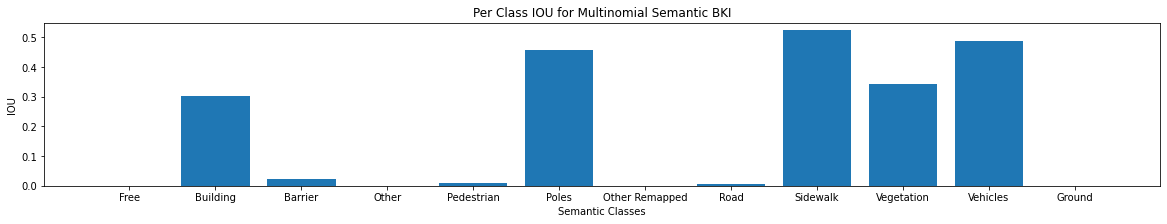

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

remapped_class_to_labels = [
    "Free",
    "Building",
    "Barrier",
    "Other",
    "Pedestrian",
    "Poles",
    "Other Remapped",
    "Road",
    "Sidewalk",
    "Vegetation",
    "Vehicles",
    "Ground"
]

# Cell for SBKI Tests
print("Visualizing Jaccard Score for Multi-BKI")
for i in range(0, len(jaccard_score_result)):
  print(remapped_class_to_labels[i], ": ", jaccard_score_result[i])

# Visualize Histogram
plt.figure(figsize=(20, 3))  # width:10, height:8
plt.bar(remapped_class_to_labels, jaccard_score_result)
plt.xlabel("Semantic Classes")
plt.ylabel("IOU")
plt.title("Per Class IOU for Multinomial Semantic BKI")
plt.show()

Visualizing Jaccard Score for SBKI
Free :  0.0
Building :  0.2710285116926819
Barrier :  0.0029933493951663968
Other :  0.0
Pedestrian :  0.0026041191647951734
Poles :  0.30792286379901485
Other Remapped :  0.000546663309900517
Road :  0.00894392576353252
Sidewalk :  0.48455755397135614
Vegetation :  0.2904246392430826
Vehicles :  0.4506734834960492
Ground :  0.0


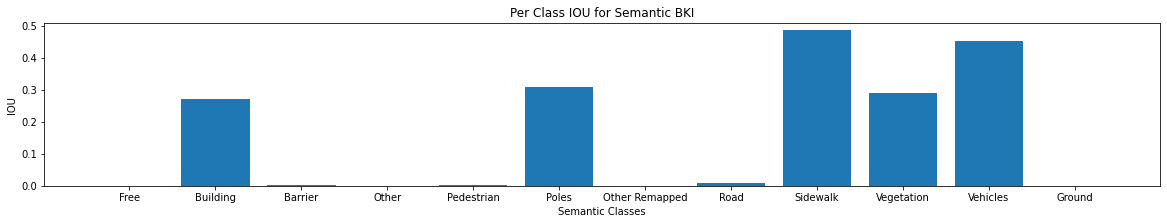

In [ ]:
#DO NOT EDIT
import matplotlib.pyplot as plt
import pandas as pd

remapped_class_to_labels = [
    "Free",
    "Building",
    "Barrier",
    "Other",
    "Pedestrian",
    "Poles",
    "Other Remapped",
    "Road",
    "Sidewalk",
    "Vegetation",
    "Vehicles",
    "Ground"
]

# Cell for SBKI Tests
print("Visualizing Jaccard Score for CatBKI")
for i in range(0, len(jaccard_score_result)):
  print(remapped_class_to_labels[i], ": ", jaccard_score_result[i])

# Visualize Histogram
plt.figure(figsize=(20, 3))  # width:10, height:8
plt.bar(remapped_class_to_labels, jaccard_score_result)
plt.xlabel("Semantic Classes")
plt.ylabel("IOU")
plt.title("Per Class IOU for Categorical BKI")
plt.show()